In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
import tensorflow as tf

In [ ]:
df = pd.read_csv('dataset_josua_new.csv')

X = df['text'].values
y = df['final_sentiment'].values

In [ ]:
w2v_model = Word2Vec.load('skipgram_wiki_word2vec_gensim3.model')

In [ ]:
texts = [text.split() for text in X]

In [ ]:
word_index = {word: idx for idx, word in enumerate(w2v_model.wv.index_to_key)}

In [ ]:
embedding_matrix = np.zeros((len(word_index), 300))
for word, idx in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

In [ ]:
sequences = [[word_index.get(word, 0) for word in text] for text in texts]
max_length = max(len(seq) for seq in sequences)
X_padded = pad_sequences(sequences, maxlen=max_length)

# Membagi Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y,
                                                    test_size=0.2,
                                                    random_state=42)
X_original_train, X_original_test = train_test_split(df['text'].values, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Embedding(len(word_index),
             weights=[embedding_matrix],
             input_length=max_length,
             trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              restore_best_weights=True)

history = model.fit(X_train, y_train,
                   epochs=30,
                   batch_size=32,
                   validation_split=0.2,
                   callbacks=[early_stopping])

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6426 - loss: 0.6169 - val_accuracy: 0.8892 - val_loss: 0.2844
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8866 - loss: 0.2742 - val_accuracy: 0.9151 - val_loss: 0.2309
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9170 - loss: 0.2266 - val_accuracy: 0.9195 - val_loss: 0.2096
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9307 - loss: 0.1983 - val_accuracy: 0.9272 - val_loss: 0.1948
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9379 - loss: 0.1676 - val_accuracy: 0.9294 - val_loss: 0.1824
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9549 - loss: 0.1399 - val_accuracy: 0.9250 - val_loss: 0.1827
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9606 - loss: 0.1242 - val_accuracy: 0.9344 - val_loss: 0.1757
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9655 - loss: 0.1099 - val_

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9413 - loss: 0.1716
Test accuracy: 0.9440
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
F1 score: 0.9494


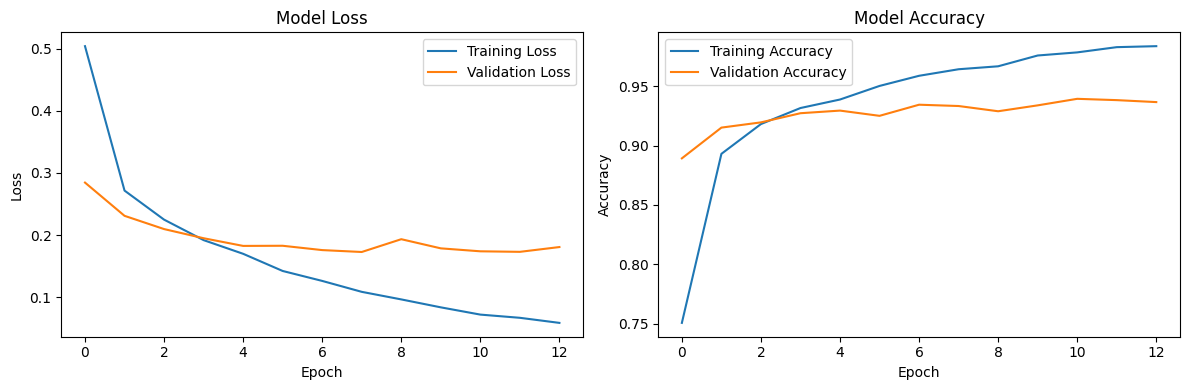

In [ ]:
from sklearn.metrics import f1_score

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
print(f'F1 score: {f1:.4f}')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pickle

# Save the model to a pickle file
with open('sentiment_analysis_model.pkl', 'wb') as file:
    pickle.dump(model, file)

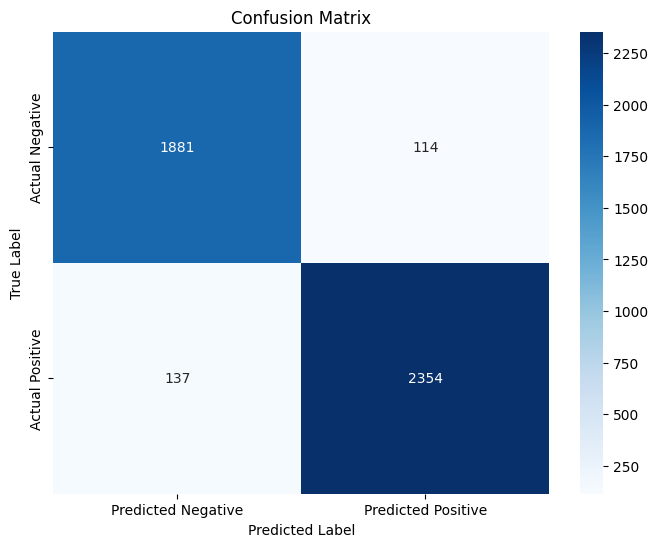

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
def predict_sentiment(text, model, word_index, max_length):
    words = text.split()
    sequence = [word_index.get(word, 0) for word in words]
    padded = pad_sequences([sequence], maxlen=max_length)
    prediction = model.predict(padded)[0][0]
    sentiment = 'Positive' if prediction > 0.5 else 'Negative'
    return sentiment, prediction

# Example usage
sample_text = "pegawai mcdonalds jadi korban"
sentiment, confidence = predict_sentiment(sample_text, model, word_index, max_length)
print(f'Text: {sample_text}')
print(f'Sentiment: {sentiment}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Text: pegawai mcdonalds jadi korban
Sentiment: Negative


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9417 - loss: 0.1491
Test Loss: 0.1600, Test Accuracy: 0.9387
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [ ]:
results = pd.DataFrame({
    'Original Text': X_original_test,
    'True Label': y_test,
    'Predicted Label': y_pred.flatten()
})

In [ ]:
results.to_csv('model_predictions_human_readable.csv', index=False)
print("Results saved to 'model_predictions_human_readable.csv'")

Results saved to 'model_predictions_human_readable.csv'


In [ ]:
misclassified = results[results['True Label'] != results['Predicted Label']]

# Save misclassified samples to a separate CSV
misclassified.to_csv('misclassified_samples.csv', index=False)
print("Misclassified samples saved to 'misclassified_samples.csv'")

Misclassified samples saved to 'misclassified_samples.csv'
